# IS403.N22.HTCL
```python
Team 16
```
**SỬ DỤNG ĐỂ TÍNH TOÁN BỘ DỮ LIỆU GIÁ VÀNG (19/05/2018 ĐẾN 19/05/2023)**
- Tỷ lệ tính toán Train Data: 70% Dataset
- Tỷ lệ tính toán Test Data: 20% Dataset
- Tỷ lệ tính toán Validation Data: 10% Dataset

In [23]:
#Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error

In [24]:
#Đọc file dữ liệu và xem dữ liệu
df = pd.read_csv('../GoldData.csv',parse_dates=True)
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL
0,21/5/2018,1290.9,1290.3,1292.7,1281.2,328.02K
1,22/5/2018,1292.0,1292.3,1296.0,1287.2,291.72K
2,23/5/2018,1289.6,1290.6,1298.4,1286.7,402.34K
3,24/5/2018,1304.4,1293.3,1306.4,1292.2,432.42K
4,25/5/2018,1303.7,1304.0,1307.2,1299.4,292.91K
...,...,...,...,...,...,...
1291,15/5/2023,2018.0,2013.8,2017.1,2013.8,0.00K
1292,16/5/2023,1988.4,2021.3,2022.7,1989.1,0.05K
1293,17/5/2023,1980.7,1983.6,1983.6,1983.6,0.01K
1294,18/5/2023,1956.5,1956.8,1956.8,1956.8,0.02K


In [25]:
#Xem các dữ liệu cơ bản của cảc thuộc tính
df.describe()

,Lần cuối,Mở,Cao,Thấp
count,1296.000000,1296.000000,1296.000000,1296.000000
mean,1657.157253,1657.419946,1668.953858,1645.013889
std,247.037374,247.289166,250.206107,243.663453
min,1184.000000,1180.700000,1189.000000,1167.100000
25%,1467.675000,1465.800000,1473.625000,1459.100000
50%,1751.750000,1751.550000,1761.200000,1735.750000
75%,1841.325000,1840.725000,1853.300000,1828.425000
max,2069.400000,2076.400000,2089.200000,2049.000000


In [26]:
#Kiểm tra dữ liệu rỗng
df.isnull().sum()

Ngày        0
Lần cuối    0
Mở          0
Cao         0
Thấp        0
KL          6
dtype: int64

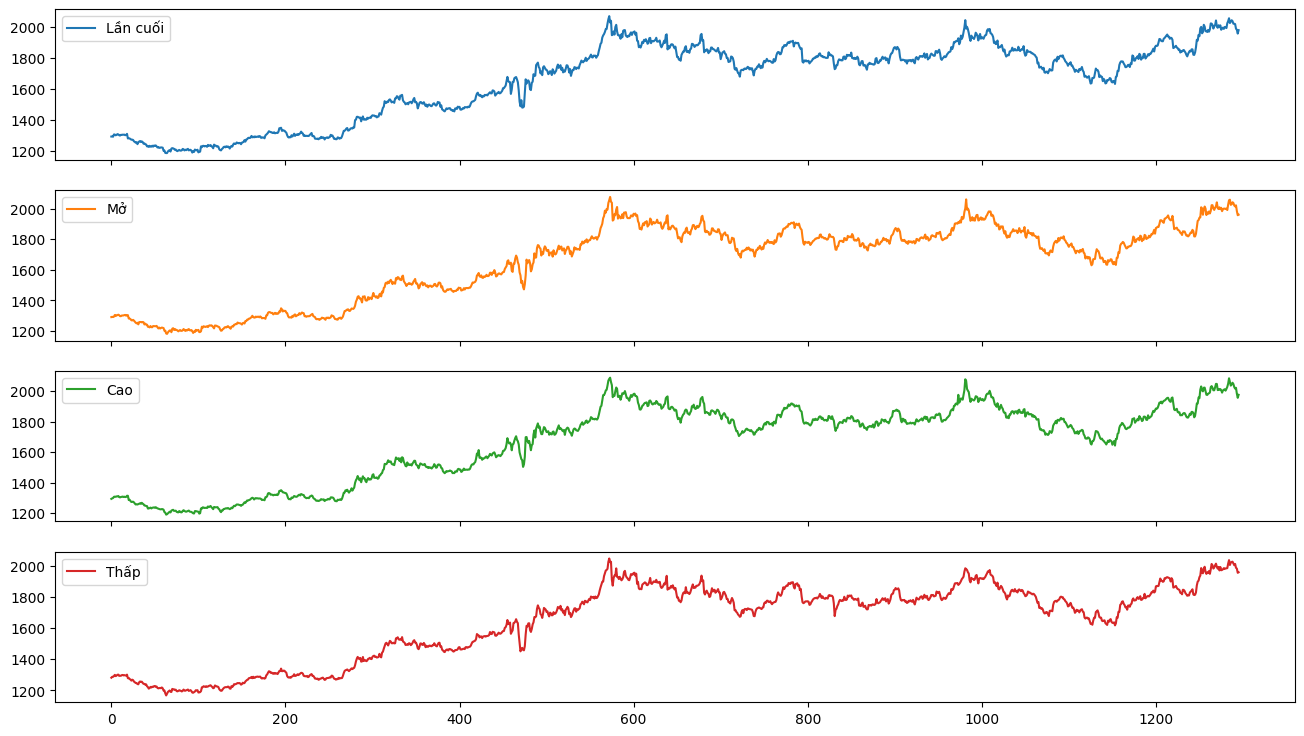

In [27]:
#Xem độ biến thiên của từng thuộc tính.
df.plot(legend=True,subplots=True, figsize = (16, 9))
plt.show()

In [28]:
#Chuyển dataset về cột Close để tiến hành tạo model
df = df[['Lần cuối']]
df

,Lần cuối
0,1290.9
1,1292.0
2,1289.6
3,1304.4
4,1303.7
...,...
1291,2018.0
1292,1988.4
1293,1980.7
1294,1956.5


In [29]:
#Chia dữ liệu theo các tỷ lệ 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data_df = df[:train_size]
test_data_df = df[train_size:train_size+test_size]
val_data_df = df[train_size+test_size:]

In [30]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [31]:
#Chia data đã Scaler
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [32]:
#Tạo hàm create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)


In [33]:
#Chia thành các tập X,y
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
print(y_train)

[6.29094195e-02 4.89044500e-02 4.95821098e-02 4.51773210e-02
 5.31962955e-02 4.69844138e-02 4.68714705e-02 5.39868986e-02
 4.70973571e-02 5.50033883e-02 5.36480687e-02 5.60198780e-02
 4.92432799e-02 4.07725322e-02 4.42737746e-02 3.80618929e-02
 3.87395527e-02 4.17890219e-02 4.05466456e-02 3.95301559e-02
 1.68285521e-02 1.88615315e-02 1.12943302e-03 0.00000000e+00
 2.25886605e-04 1.19719901e-02 1.80709284e-02 2.17980574e-02
 1.12943302e-02 3.30923876e-02 3.61418568e-02 3.43347639e-02
 3.10594082e-02 2.37180935e-02 2.56381297e-02 1.70544387e-02
 1.42308561e-02 1.95391913e-02 2.29274904e-02 1.85227016e-02
 1.78450418e-02 2.05556810e-02 3.03817484e-02 2.73322792e-02
 1.93133047e-02 2.46216399e-02 2.13462842e-02 2.74452225e-02
 3.08335216e-02 1.95391913e-02 2.30404337e-02 2.38310368e-02
 1.70544387e-02 3.84007228e-03 1.37790829e-02 8.69663429e-03
 2.59769596e-02 2.13462842e-02 1.98780212e-02 2.43957533e-02
 5.19539191e-03 8.47074768e-03 1.06166704e-02 4.92432799e-02
 4.29184549e-02 5.229274

In [34]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
# X_train = X_train.reshape(X_train.shape[0],1, X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1] , 1)
# X_val = X_val.reshape(X_val.shape[0],1 ,X_val.shape[1] , 1)


In [35]:
import tensorflow as tf
from tensorflow.keras import layers

class MultiscaleRNN(tf.keras.Model):
    def __init__(self, num_units, dilation_factors):
        super(MultiscaleRNN, self).__init__()
        self.num_units = num_units
        self.dilation_factors = dilation_factors
        self.rnn_layers = []

        # Create recurrent layers with different time strides
        for dilation_factor in dilation_factors:
            rnn_layer = layers.GRU(num_units, return_sequences=False, go_backwards=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform', recurrent_dropout=0.0)
            self.rnn_layers.append(rnn_layer)
        
        # Add the FCNN component
        self.fcnn_layer = layers.Dense(num_units, activation='relu')

    def call(self, inputs):
        outputs = []

        # Apply each recurrent layer to the inputs
        for rnn_layer in self.rnn_layers:
            output = rnn_layer(inputs)
            outputs.append(output)

        # Concatenate the outputs from different time strides
        outputs = tf.concat(outputs, axis=-1)
        
        # Apply the FCNN component
        outputs = self.fcnn_layer(outputs)

        return outputs

# Define the parameters for the MultiscaleRNN
num_units = 16
dilation_factors = [1, 2, 4, 8]  # Example dilation factors, adjust as needed

# Define the input shape
input_shape = (None, 1)

# Create the input layer
inputs = layers.Input(input_shape)

# Create the multiscale RNN layer
msrnn_layer = MultiscaleRNN(num_units, dilation_factors)
outputs = msrnn_layer(inputs)

# Create the output layer
outputs = layers.Dense(1)(outputs)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Final layers
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# Fit model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=100
)

Epoch 1/100
28/28 [==============================] - 8s 63ms/step - loss: 0.1220 - mse: 0.1220 - mae: 0.2544 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0878
Epoch 2/100
28/28 [==============================] - 0s 18ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0978 - val_loss: 0.0099 - val_mse: 0.0099 - val_mae: 0.0756
Epoch 3/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0099 - mse: 0.0099 - mae: 0.0809 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0797
Epoch 4/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0737 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0843
Epoch 5/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0708 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0867
Epoch 6/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0681 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0851
Epoch 7/100
28/2

In [36]:
# Dự đoán

# Dự đoán train
y_pred_train=model.predict(X_train)
y_train=scaler.inverse_transform(y_train.reshape(-1,1))
y_pred_train=scaler.inverse_transform(y_pred_train.reshape(-1,1))
#Dự đoán Test
y_pred_test=model.predict(X_test)
y_test=scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_test=scaler.inverse_transform(y_pred_test.reshape(-1,1))
#Dự đoán Validation
y_pred_val=model.predict(X_val)
y_val=scaler.inverse_transform(y_val.reshape(-1,1))
y_pred_val=scaler.inverse_transform(y_pred_val.reshape(-1,1))

3/3 [==============================] - 0s 4ms/step


In [37]:
# Print the length
print(y_pred_test.shape[0])
print(y_test.shape[0])
print(y_pred_train.shape[0])
print(y_train.shape[0])

218
218
866
866


In [38]:
#Hàm visualize
def visualize(label ,pred, model_name):
  plt.figure(figsize=(12,8))
  plt.plot(label, label = 'Ground truth')
  plt.plot(pred, label='Predict')
  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [39]:
#8. Đánh giá 
def deviation(test, pred):
  rmse= np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape= mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mae = mean_absolute_error(test, pred)
  print(f"MAE: {mae:.2f}")

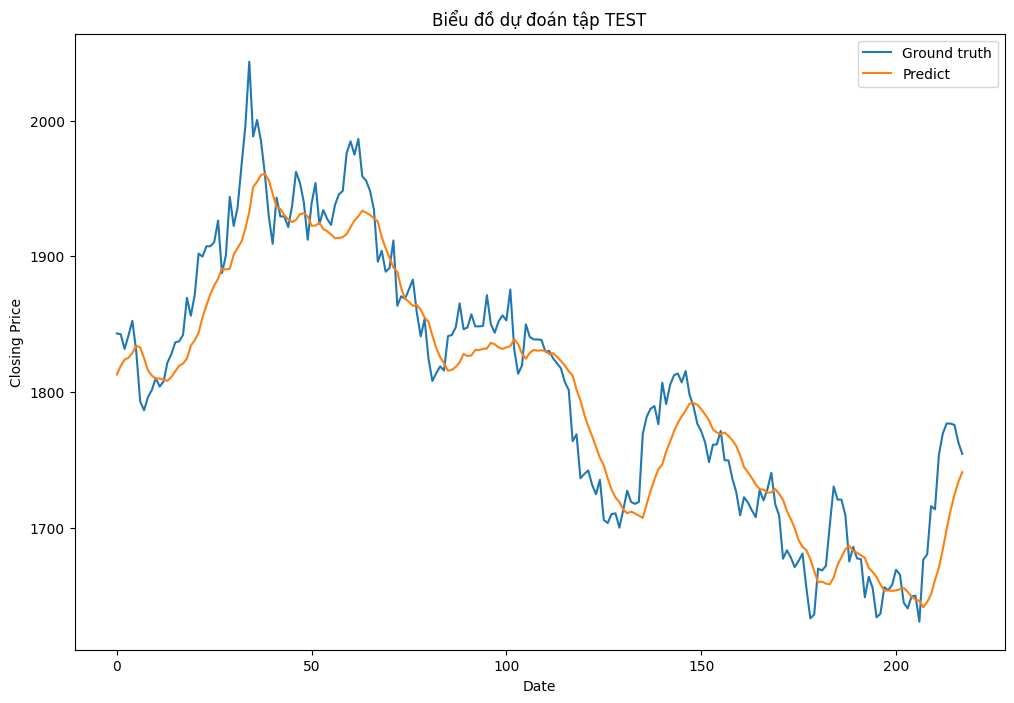

Đánh Giá tập TEST
RMSE: 30.88
MAPE: 1.34%
MAE: 24.34


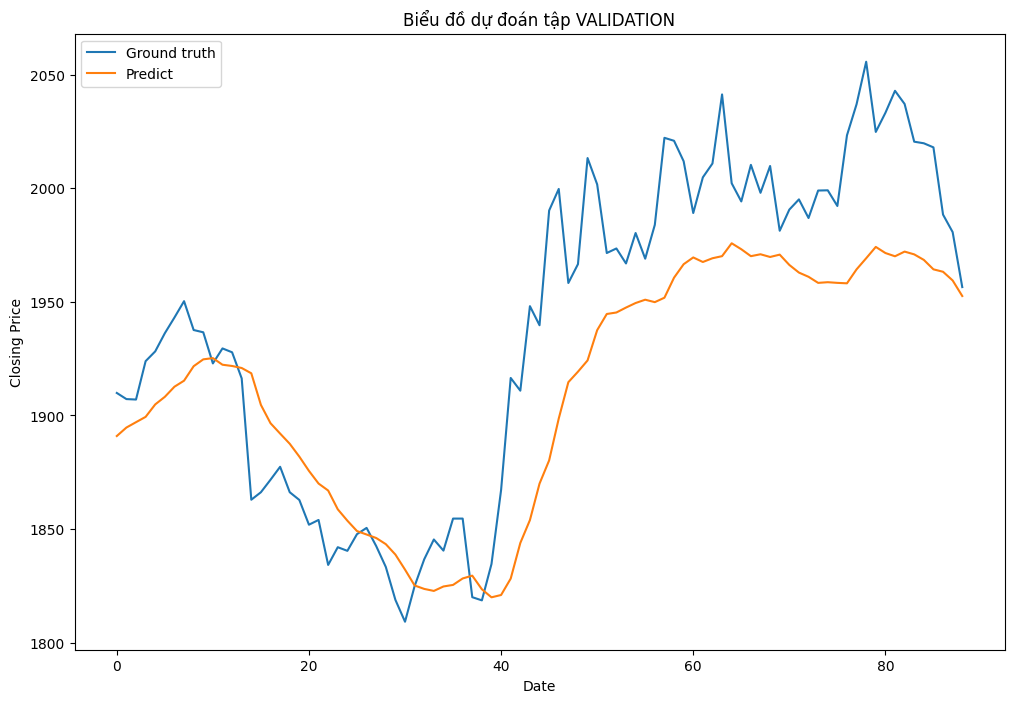

Đánh Giá tập VALIDATION
RMSE: 42.63
MAPE: 1.75%
MAE: 34.50


In [40]:
# visualize(y_train,y_pred_train,'Biểu đồ dự đoán tập TRAIN')
visualize(y_test,y_pred_test,'Biểu đồ dự đoán tập TEST')
print('Đánh Giá tập TEST')
deviation(y_test, y_pred_test)
visualize(y_val,y_pred_val,'Biểu đồ dự đoán tập VALIDATION')
print('Đánh Giá tập VALIDATION')
deviation(y_val, y_pred_val)

In [41]:
#Dự đoán 30 ngày tiếp theo
pred_next = np.array([])
  
y_val_to_next=scaler.fit_transform(np.array(y_val[-time_step:].reshape(1,-1).reshape(1,time_step)).reshape(-1,1))
  
for i in range(30):
    print(y_val_to_next)
    y_pred_next = model.predict(y_val_to_next.reshape(1,-1))
    y_val_to_next = np.append(y_val_to_next,y_pred_next[0])[1:]
    pred_next = np.append(pred_next,y_pred_next[0])
    
next30days_predict_inverse = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1,1)))


[[0.57258065]
 [0.45564516]
 [0.15120968]
 [0.17137097]
 [0.10483871]
 [0.23991935]
 [0.12600806]
 [0.27620968]
 [0.66229839]
 [0.64919355]
 [0.55846774]
 [0.32862903]
 [0.48689516]
 [0.5483871 ]
 [0.85483871]
 [0.46068548]
 [0.38004032]
 [0.54233871]
 [0.41834677]
 [0.53729839]
 [0.25      ]
 [0.34375   ]
 [0.3891129 ]
 [0.30645161]
 [0.42842742]
 [0.42943548]
 [0.35987903]
 [0.6733871 ]
 [0.81149194]
 [1.        ]
 [0.68850806]
 [0.77318548]
 [0.87096774]
 [0.8125    ]
 [0.64516129]
 [0.63810484]
 [0.61995968]
 [0.32157258]
 [0.24395161]
 [0.        ]]
1/1 [==============================] - 0s 32ms/step
[0.45564516 0.15120968 0.17137097 0.10483871 0.23991935 0.12600806
 0.27620968 0.66229839 0.64919355 0.55846774 0.32862903 0.48689516
 0.5483871  0.85483871 0.46068548 0.38004032 0.54233871 0.41834677
 0.53729839 0.25       0.34375    0.3891129  0.30645161 0.42842742
 0.42943548 0.35987903 0.6733871  0.81149194 1.         0.68850806
 0.77318548 0.87096774 0.8125     0.64516129 0.63810

In [42]:
next30days_predict_inverse

,0
0,2004.773385
1,2006.269531
2,2008.253819
3,2008.825295
4,2009.594980
5,2009.585413
6,2010.286568
7,2009.262338
8,2007.394006
9,2007.577728


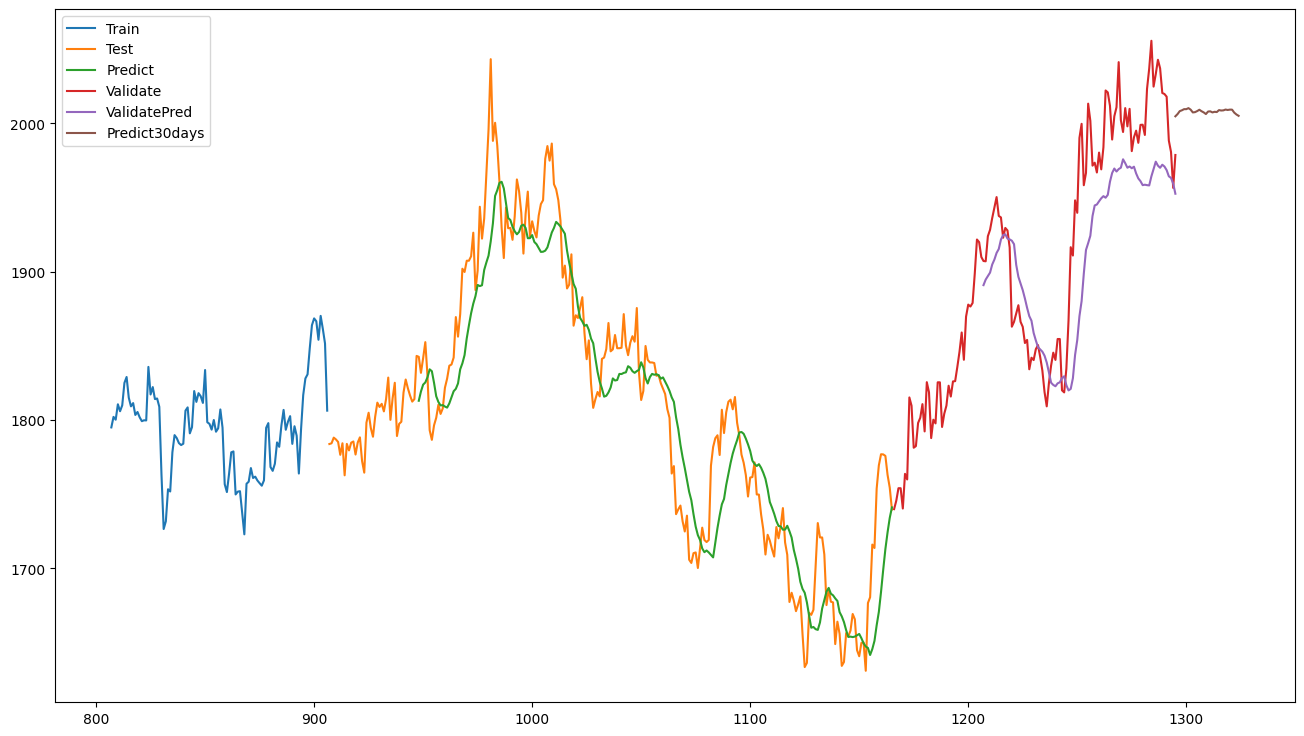

In [43]:
# Vẽ hình
plt.figure(figsize=(16,9))

train_data_index = pd.RangeIndex(start=train_size-100, stop=train_size, step=1)
plt.plot(train_data_index,train_data_df[train_size-100:])

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, test_data_df)

test_data_index = pd.RangeIndex(start=train_size+ 41, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_test)

val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, val_data_df)

val_data_index = pd.RangeIndex(start=train_size + test_size+ 41, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)


prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,next30days_predict_inverse)

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [44]:
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 multiscale_rnn_1 (Multiscal  (None, 16)               4688      
 eRNN)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
